<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/reg_ativa_exemplos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplos e simulações iniciais para nosso metodo de regressão ativa

In [ ]:
# pacotes
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# montando o colab
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/active_learning/figuras'

Mounted at /content/gdrive


Simulando dados de uma regressão linear apenas para testar se funciona a implementação do método pelo modAL:

In [ ]:
# gerando os X's
np.random.seed(1500)
n = 1200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + np.random.normal(loc = 0, scale = 0.25, size = n)


sim_data = pd.DataFrame(data = {'X' : X,
                                'Y' : y})

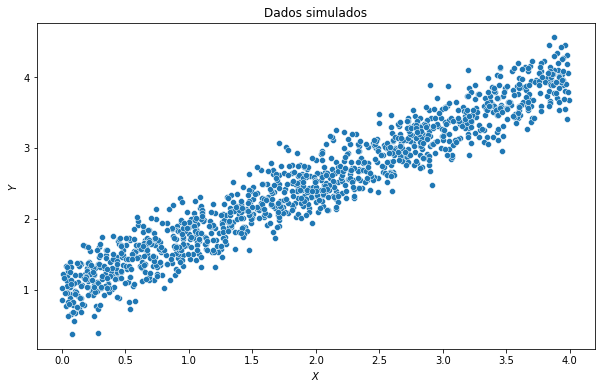

In [ ]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = sim_data, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

Dividindo em treino e teste e pegando apenas 5 pontos iniciais para treinamento:

In [ ]:
X.reshape(-1, 1)

array([[3.93806007],
       [0.40077993],
       [2.85393987],
       ...,
       [0.64070165],
       [3.18931425],
       [1.58891887]])

In [ ]:
from sklearn.model_selection import train_test_split
# teste para ver desempenho depois
X_pool, X_test, y_pool, y_test = train_test_split(X.reshape(-1, 1), y, test_size = 0.2, random_state=42)

# setando as amostras iniciais:
np.random.seed(2018)
# 20 de treinamento inicial
n_initial = 5
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

Criando a estrategia de consulta por hora com um 2-fold:

In [ ]:
from sklearn.model_selection import KFold
!pip install modAL
from modAL import ActiveLearner

# colocar depois outro nome
def bias_reduction(regressor, X, k = 2, random_state = 99):
  # splitting into two folds:
  kf = KFold(n_splits = k, random_state = random_state, shuffle = True)
  # obtaining labeled data by regressor
  X_labeled, y_labeled = regressor.X_training, regressor.y_training

  errors = np.zeros((X.shape[0], k))
  # K-fold loop
  i = 0
  for train_idx, test_idx in kf.split(X_labeled):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # first, fitting the current training data
    train_learner = regressor.estimator.fit(X = X_train, y = y_train)

    # now obtaining Z
    z = y_test - train_learner.predict(X_test)

    # fitting the regression on z
    valid_learner = regressor.estimator.fit(X = X_test, y = y_test)

    # now obtaining the errors for each observation in the pool
    errors[:, i] = valid_learner.predict(X)
    i += 1
  
  # obtaining scores by computing the row-wise means of errors
  scores = errors.mean(axis=1)

  # sorting index in descending order
  ranked = np.argsort(scores)
  query_idx = ranked[::-1][0]

  # finally returning the index
  return query_idx, X[query_idx]

Testando por hora no exemplo simples essa estratégia e vendo se funciona

In [ ]:
# initializing learner
from sklearn.linear_model import LinearRegression

reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)

Analisando o comportamento dessa estratégia:

In [ ]:
from sklearn.metrics import mean_squared_error
n_queries = 25
list_mse = [mean_squared_error(y_test, reg_mod.predict(X_test))]

In [ ]:
# lasso do aprendizado ativo:
for index in range(n_queries):
  query_idx, query_instance = reg_mod.query(X_pool, k = 2)
  X_sel, y_sel = X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1, )
  reg_mod.teach(X = X_sel, y = y_sel)

  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  list_mse.append(mean_squared_error(y_test, reg_mod.predict(X_test)))

In [ ]:
indexes = np.arange(0, 26)
indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

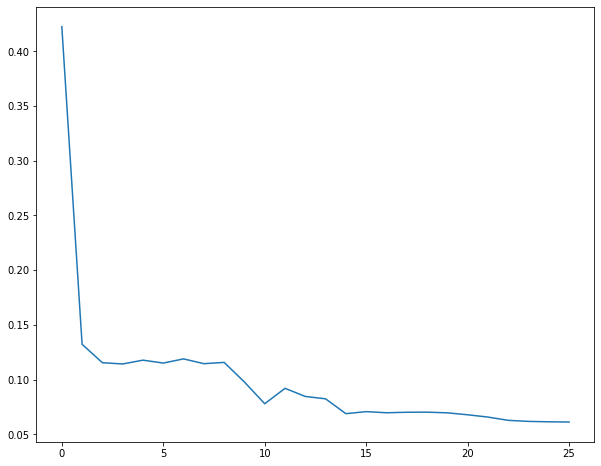

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(indexes, list_mse)
plt.show()